In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Built-in
import os
from pathlib import Path

# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler

# Local
from adad.distance import DAIndexDelta, DAIndexGamma, DAIndexKappa
from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)
from adad.utils import category2code, drop_redundant_col, maccs2binary


In [3]:
plt.rcParams["font.size"] = 16

In [4]:
# Step 1: Load data
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_MACCS.csv")
file_idx_train = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_test.csv")

/home/lukec/workspace/applicabilityDomain


In [5]:
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_train.iloc[-5:]

,cv1,cv2,cv3,cv4,cv5
5523,6476,6477,6476,6489,6502
5524,6477,6479,6477,6492,6508
5525,6479,6489,6479,<NA>,<NA>
5526,6489,6492,6489,<NA>,<NA>
5527,6492,<NA>,6492,<NA>,<NA>


In [6]:
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())
idx_test.iloc[-5:]

,cv1,cv2,cv3,cv4,cv5
982,6497,6504,6494,6471,6476
983,6498,6505,6501,6482,6477
984,<NA>,6510,<NA>,6496,6479
985,<NA>,<NA>,<NA>,6502,6489
986,<NA>,<NA>,<NA>,6508,6492


In [7]:
data = pd.read_csv(file_data)
data["y"] = data["y"].astype("category").cat.codes
print("Labels:", data["y"].unique())
print("Shape:", data.shape)
data.head()

Labels: [0 1]
Shape: (6512, 167)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x158,x159,x160,x161,x162,x163,x164,x165,x166,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,2.0,1.0,42.0,6.0,44.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,6.0,2.0,6.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,4.0,0.0,6.0,3.0,6.0,0.0,1


In [8]:
# Only load one CV split
indices_train = []
indices_test = []
for c in idx_train.columns:
    indices_train.append(idx_train[c].dropna(axis=0).to_numpy().astype(int))
    indices_test.append(idx_test[c].dropna(axis=0).to_numpy().astype(int))

# Check if any index from test set is also in train set
for i in range(len(indices_train)):
    assert not np.all(np.isin(indices_test[i], indices_train[i]))

In [9]:
y = data['y'].to_numpy().astype(int)

# Drop columns with no information for training.
data = drop_redundant_col(data)
X = data.drop(['y'], axis=1).to_numpy()

In [10]:
# Change any value greater than 1 to 1
X = maccs2binary(X)

In [11]:
N_TREES = 100

clfs = []
for i in range(len(indices_train)):
    X_train, X_test = X[indices_train[i]], X[indices_test[i]]
    y_train, y_test = y[indices_train[i]], y[indices_test[i]]

    SEED = np.random.randint(1000, 999999)
    print("SEED:", SEED)
    _clf = RandomForestClassifier(n_estimators=N_TREES, random_state=SEED)
    _clf.fit(X_train, y_train)
    clfs.append(_clf)

    acc_train = _clf.score(X_train, y_train)
    acc_test = _clf.score(X_test, y_test)
    print(f'[Accuracy] Train: {acc_train*100:.2f}%, test: {acc_test*100:.2f}%')

SEED: 275939
[Accuracy] Train: 97.67%, test: 77.44%
SEED: 819206
[Accuracy] Train: 97.41%, test: 80.10%
SEED: 902723
[Accuracy] Train: 97.58%, test: 80.08%
SEED: 789099
[Accuracy] Train: 97.67%, test: 79.84%
SEED: 69952
[Accuracy] Train: 97.57%, test: 78.12%


In [12]:
ads = []
for clf in clfs:
    _ad = DAIndexKappa(clf=clf, k=5, dist_metric='jaccard')
    _ad.fit(X_train, y_train)
    ads.append(_ad)

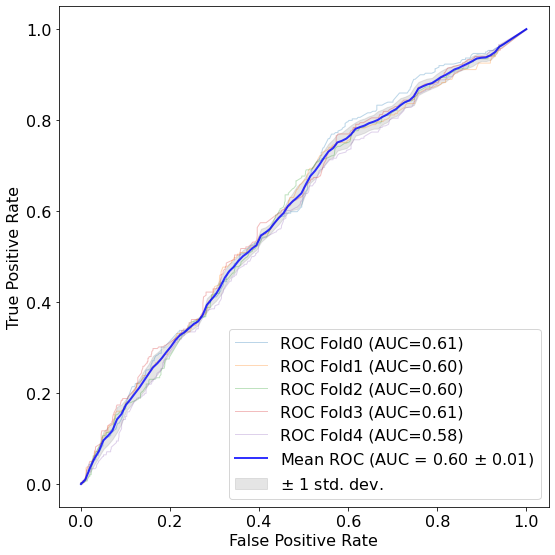

Mean Perm. AUC: 0.5963692869969901


In [15]:
# Step 3: Train AD
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
perm_aucs = []

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(clfs)):
    y_pred = clf[i].predict(X_test)

    dm = ads[i].measure(X_test)
    # dm = 1. / (dm + 1e-6)

    perm_auc, _ = permutation_auc(y_test, y_pred, dm)
    perm_aucs.append(perm_auc)

    fpr, tpr = roc_ad(y_test, y_pred, dm)
    roc_auc = auc(fpr, tpr)

    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(ax=ax, alpha=0.3, lw=1, label=f"ROC Fold{i} (AUC={roc_auc:.2f})" )

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color='b',
    label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label="$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print('Mean Perm. AUC:', np.mean(perm_aucs))